In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import csv
import os

In [4]:
class ZebrafishDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
    

In [5]:
images_path = "E:\Code\Zebra_Fish_Detection_And_Tracking\data\interim\X_labelled_data.npy"
labels_path = "E:\Code\Zebra_Fish_Detection_And_Tracking\data\interim\y_labelled_data.npy"

transform = transforms.ToTensor()
dataset = ZebrafishDataset(images_path, labels_path, transform=transform)

train_size = int(0.7 * dataset.__len__())
val_size = int(0.15 * dataset.__len__())
test_size = dataset.__len__() - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
train_loader = DataLoader(dataset = train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=16, shuffle=True)

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128 * 26 * 26, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=4)
        
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
                
        x = self.flatten(x)
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x
        

In [8]:
model = CNNModel()
mse_loss_function = nn.MSELoss()
mae_loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
def Initialize_writer(file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, mode='w', newline="") as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'loss', 'val_loss'])

In [8]:
def validate(model, val_loader, mse_loss_function, mae_loss_function):
    model.eval()
    mse_running_loss = 0.0
    mae_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            
            mse_loss = mse_loss_function(outputs, labels)
            mae_loss = mae_loss_function(outputs, labels)
            
            mse_running_loss += mse_loss.item()
            mae_running_loss += mae_loss.item()
        
        mse_avg_loss = mse_running_loss / len(val_loader)
        mae_avg_loss = mae_running_loss / len(val_loader)
        
        print(f"MSE: {mse_avg_loss:.4f}, MAE: {mae_avg_loss:.4f}", end=" ")
        return mse_avg_loss, mae_avg_loss

In [9]:
def train(model, train_loader, optimizer, 
          mse_loss_function, mae_loss_function,
          mse_history_csv_path, mae_history_csv_path, 
          save_model_checkpoint_path, num_epochs=1):
    
    Initialize_writer(mse_history_csv_path)
    Initialize_writer(mae_history_csv_path)
    
    best_val_mse_loss = float('inf')
    
    model.train()
        
    for epoch in range(num_epochs):
        mse_running_loss = 0.0
        mae_running_loss = 0.0  
        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            mse_loss = mse_loss_function(outputs, labels)
            mae_loss = mae_loss_function(outputs, labels)
            
            mse_loss.backward()
            
            optimizer.step()
            
            mse_running_loss += mse_loss.item()
            mae_running_loss += mae_loss.item()  
            
        mse_avg_loss = mse_running_loss / len(train_loader)
        mae_avg_loss = mae_running_loss / len(train_loader)
        
        print(end='\n')
        print(f"Epoch [{epoch+1}/{num_epochs}], MSE: {mse_avg_loss:.4f}, MAE: {mae_avg_loss:.4f}", end=" --- ")
        print(f"Validation for Epoch [{epoch+1}/{num_epochs}]", end=", ")
        val_mse_loss, val_mae_loss = validate(model, val_loader, mse_loss_function, mae_loss_function)
        
        
        if val_mse_loss < best_val_mse_loss:
            best_val_mse_loss = val_mse_loss
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            print("\n")
            print(f"=========Saving Checkpoint======= at Epoch:[{epoch+1}/{num_epochs}]", end="\n")
            torch.save(checkpoint, save_model_checkpoint_path)

        
        with open(mse_history_csv_path, mode='a', newline="") as file:
            mse_writer = csv.writer(file)
            mse_writer.writerow([epoch+1, mse_avg_loss, val_mse_loss])
        
        with open(mae_history_csv_file, mode = 'a', newline="") as file:
            mae_writer = csv.writer(file)
            mae_writer.writerow([epoch+1, mae_avg_loss, val_mae_loss])     
            
    print(f'The best Validation Loss is: {best_val_mse_loss}')
                

In [10]:
mse_history_csv_file = "E:\Code\Zebra_Fish_Detection_And_Tracking\models\model_history/CNN_mse_loss_logger.csv"
mae_history_csv_file = "E:\Code\Zebra_Fish_Detection_And_Tracking\models\model_history/CNN_mae_loss_logger.csv"
checkpoints_file = 'E:\Code\Zebra_Fish_Detection_And_Tracking\models\CNN_checkpoint.pth.tar'

In [11]:
train(model, train_loader, optimizer, mse_loss_function, mae_loss_function, 
      mse_history_csv_path=mse_history_csv_file, mae_history_csv_path=mae_history_csv_file,
      save_model_checkpoint_path=checkpoints_file, num_epochs=10)

C:\Users\HARSHU\AppData\Local\Temp\ipykernel_16340\83796796.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)



Epoch [1/10], MSE: 0.0272, MAE: 0.1163 --- Validation for Epoch [1/10], MSE: 0.0039, MAE: 0.0419 

=========Saving Checkpoint======= at Epoch:[1/10]

Epoch [2/10], MSE: 0.0132, MAE: 0.0653 --- Validation for Epoch [2/10], MSE: 0.0030, MAE: 0.0414 

=========Saving Checkpoint======= at Epoch:[2/10]

Epoch [3/10], MSE: 0.0118, MAE: 0.0650 --- Validation for Epoch [3/10], MSE: 0.0036, MAE: 0.0388 
Epoch [4/10], MSE: 0.0119, MAE: 0.0632 --- Validation for Epoch [4/10], MSE: 0.0044, MAE: 0.0380 
Epoch [5/10], MSE: 0.0132, MAE: 0.0673 --- Validation for Epoch [5/10], MSE: 0.0032, MAE: 0.0382 
Epoch [6/10], MSE: 0.0117, MAE: 0.0622 --- Validation for Epoch [6/10], MSE: 0.0030, MAE: 0.0401 

=========Saving Checkpoint======= at Epoch:[6/10]

Epoch [7/10], MSE: 0.0125, MAE: 0.0673 --- Validation for Epoch [7/10], MSE: 0.0029, MAE: 0.0361 

=========Saving Checkpoint======= at Epoch:[7/10]

Epoch [8/10], MSE: 0.0122, MAE: 0.0603 --- Validation for Epoch [8/10], MSE: 0.0027, MAE: 0.0376 

======

In [12]:
def test(model, test_loader, mse_loss_function, mae_loss_function):
    model.eval()
    mse_running_loss = 0.0
    mae_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            
            mse_loss = mse_loss_function(outputs, labels)
            mae_loss = mae_loss_function(outputs, labels)
            
            mse_running_loss += mse_loss.item()
            mae_running_loss += mae_loss.item()
            
    mse_avg_loss = mse_running_loss / len(test_loader)
    mae_avg_loss = mae_running_loss / len(test_loader)
    
    print(f"Test MSE Loss: {mse_avg_loss:.4f}")
    print(f"Test MAE Loss: {mae_avg_loss:.4f}")

In [13]:
test(model, test_loader, mse_loss_function, mae_loss_function)

C:\Users\HARSHU\AppData\Local\Temp\ipykernel_16340\83796796.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


Test MSE Loss: 0.0127
Test MAE Loss: 0.0636


The best loss of 0.0116993983392603 achieved at Epoch: 6


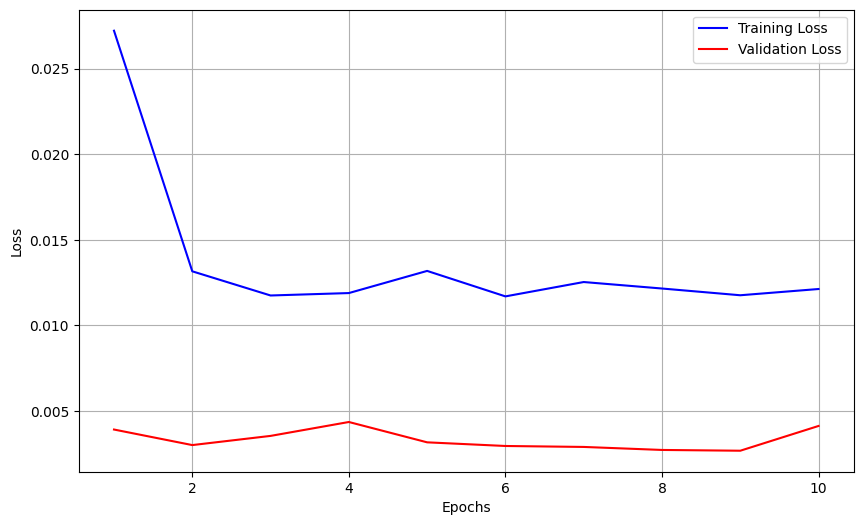

The best loss of 0.060334948512415 achieved at Epoch: 8


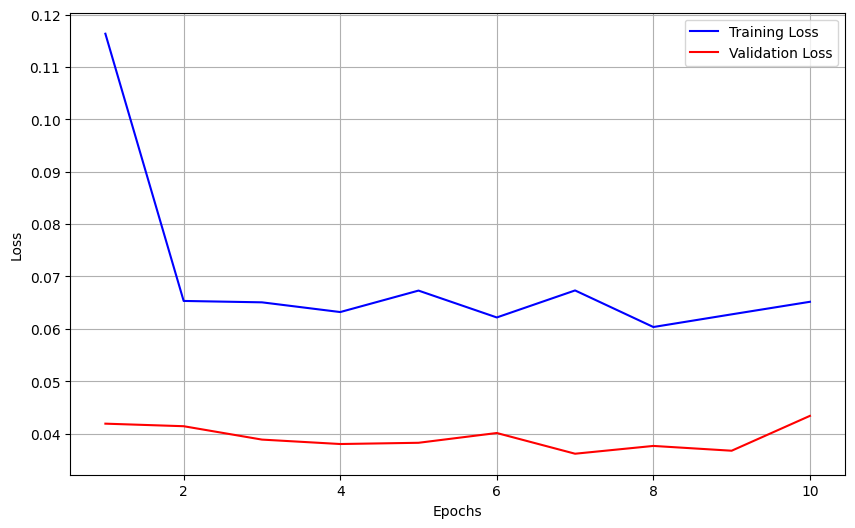

In [14]:
from loss_curve_visualization import plot_loss_curves
plot_loss_curves("E:\Code\Zebra_Fish_Detection_And_Tracking\models\model_history/CNN_mse_loss_logger.csv")
plot_loss_curves("E:\Code\Zebra_Fish_Detection_And_Tracking\models\model_history/CNN_mae_loss_logger.csv")

In [12]:
def load_checkpoint(checkpoint):
    print("loading checkpoint")
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

load_checkpoint("E:\Code\Zebra_Fish_Detection_And_Tracking\models\CNN_checkpoint.pth.tar")

loading checkpoint


C:\Users\HARSHU\AppData\Local\Temp\ipykernel_13808\497784259.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint)
